In [333]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import gensim
import nltk
import datetime
import time
import pickle
import json

from pymongo import MongoClient
from pprint import pprint
from gensim.models import CoherenceModel
from gensim.models import word2vec
from nltk import word_tokenize
from nltk.tag import StanfordNERTagger 
from nltk.corpus import stopwords

from text_processing import (tag_words,remove_stopwords,
                             remove_sw,process_doc,
                            bigrams,refactor_corpus,get_corpus)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(1960)

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [334]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Database Retrieval

Having stored my database on Mongo previously, all I need to do is connect to my database and retrieve the data. When the data is retrieved from Mongo, it comes with an extra id column. Since the id is of no use to me I will drop it and check my dataframe.

In [269]:
with open('/Users/alexanderbailey/.secret/mongo_creds.json','r') as f:
    params = json.load(f)

url = 'mongodb+srv://zmbailey:' + params['password'] + '@cluster0-ykzgc.mongodb.net/test?retryWrites=true&w=majority'

client = MongoClient(url)

In [271]:
mongodb = client.movieplots
mongo_summaries = mongodb.movies
movies = pd.DataFrame(list(mongo_summaries.find()))
movies = movies[['summary','title']]
print(movies.shape)
movies.head()

(56005, 2)


,summary,title
0,nown as 1 Life On The Limit is a 2013 document...,1 (2013 film)
1,While on the phone with his girlfriend Jill w...,+1 (film)
2,Gully Mercer Mick Rossi leads a group of prol...,2:22 (2008 film)
3,o Christmas is a Ghanaian drama movie about Re...,6 Hours To Christmas
4,r is a 1995 American romantic drama television...,The Affair (1995 film)


## Data Prepration

My dataset is a little large to work with, given the size of each text entry. Certain operations take an impractical amount of time, so I will take a smaller sample, and break that up for processing.

In [ ]:
import random
sample = random.sample(list(movies['summary']),25000)
sample1 = sample[:12501]
sample2 = sample[12501:]

In [36]:
# with open('samples.pkl','rb') as f:
#     data = pickle.load(f)
# sample = data[2]
# sample1 = data[3]
# sample2 = data[4]

In [165]:
titles = movies.loc[movies['summary'].isin(sample)]
len(titles)

25002

In [166]:
titles = titles[(titles.title != 'Island of Death (film)') & (titles.title != "God's Clay (1919 film)")]

### Name Entity Recognition

Movie summaries contain a considerable number of names, both of people and places, which throw off the topic modeling. In order to avoid this, I can use NER to identify names so I can remove them. However, NER takes a long time to run on my data, so I have commented the line out, and pickled the results so that I can quickly load it later.   

In [ ]:
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz',
                       '/Users/alexanderbailey/Documents/stanford-ner-2018-10-16/stanford-ner.jar')
#names1 = tag_words(sample1, st)
#names2 = tag_words(sample2, st)

In [ ]:
# with open('data/names_list1.pkl', 'wb') as f:
#     pickle.dump(names, f)

In [101]:
with open('data/names_list1.pkl', 'rb') as f1:
    names1 = pickle.load(f1)
with open('data/names_list2.pkl', 'rb') as f2:
    names2 = pickle.load(f2)
    
names = set(names1).union(set(names2))

In [132]:
list(names)[:10]
len(names.union(set(map(lambda x: x.lower(),names))))

113746

Now that I have the list of names I can append it to the stoplist so any names will be removed from the text.

In [131]:
names = names.union(set(map(lambda x: x.lower(),names)))
stop_words = stopwords.words('english')
stop_words += ['film', 'directed', 'film_directed', 'series',
               'story', 'american', 'starring', 'films', 'direct',
               'produced', 'stars', 'released','premiered','features',
              'featuring','interviews','release','version','performances',
              'performance','perform','titled','title','distributed','featured',
              'adaptation','character','role','including']
 
stop_words = set(stop_words).union(names)

In [327]:
# with open('data/stopwords.pkl', 'wb') as f:
#     pickle.dump(stop_words, f)

Now that we have the stopwords configured, we can preprocess the text.

In [133]:
now = datetime.datetime.now()
m_corpus, m_id2word, bigram = get_corpus(sample,stop_words)
later = datetime.datetime.now()
elapsed = later-now
print("Time: ", elapsed)

Time:  0:00:19.972509


In [324]:
with open('jar/id2word.pkl','wb') as f:
    pickle.dump(m_id2word,f)

Now I create my first test LDA model, to see what the topics are like. 

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=m_corpus,
                                       num_topics=10,
                                       id2word=m_id2word,
                                       chunksize=100,
                                       eval_every=1,
                                       per_word_topics=True,
                                       passes=20,
                                       workers=4)

for idx, topic in lda_model.print_topics(num_topics=-1):
    print('Topic : {} Word: {}'.format(idx, topic))

Now I'm creating a series of models to looks at coherence values for different numbers of topics. Coherence values are not difinitive, but they can help to suggest a trend, and provide a range of values to focus on.

In [404]:
def get_coherence_vals(start,end,step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,end,step):
        model = gensim.models.LdaMulticore(corpus=m_corpus,
                                           num_topics=num_topics,
                                           id2word=m_id2word,
                                           chunksize=100,
                                           eval_every=1,
                                           per_word_topics=True,
                                           passes=20,
                                           workers=3,
                                           random_state=85)
        model_list.append(model)

        coherencemodel = CoherenceModel(model=model, 
                                        texts=bigram,
                                        dictionary=m_id2word,
                                       coherence='c_v')
        print('model with ' + str(num_topics) + ' topics')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list,coherence_values

Doing a broad search to look for trends.

In [405]:
now = datetime.datetime.now()
models7, coherence7 = get_coherence_vals(5,20,1)
later = datetime.datetime.now()
elapsed = later-now
print("Time: ", elapsed)

model with 5 topics
model with 6 topics
model with 7 topics
model with 8 topics
model with 9 topics
model with 10 topics
model with 11 topics
model with 12 topics
model with 13 topics
model with 14 topics
model with 15 topics
model with 16 topics
model with 17 topics
model with 18 topics
model with 19 topics
Time:  0:23:19.003020


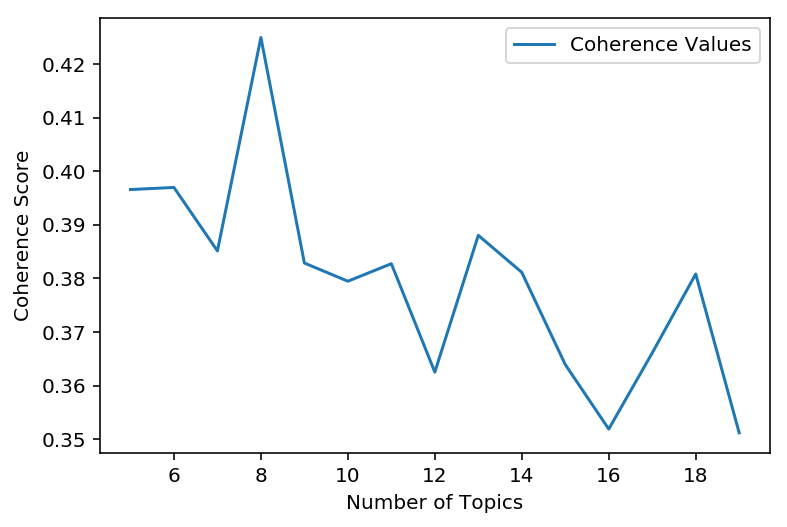

In [421]:

X = range(5,20,1)

fig, ax = plt.subplots()
ax.plot(X, coherence7, label="Coherence Values")
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Coherence Score')
plt.legend()

In [418]:
for m, cv in zip(X, coherence1):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3901
Num Topics = 6  has Coherence Value of 0.3817
Num Topics = 7  has Coherence Value of 0.3775
Num Topics = 8  has Coherence Value of 0.385
Num Topics = 9  has Coherence Value of 0.3965
Num Topics = 10  has Coherence Value of 0.38
Num Topics = 11  has Coherence Value of 0.3806
Num Topics = 12  has Coherence Value of 0.3825
Num Topics = 13  has Coherence Value of 0.4101
Num Topics = 14  has Coherence Value of 0.3784
Num Topics = 15  has Coherence Value of 0.3822


In [310]:
models4 = model_list
coherence4 = coherence_values

In [420]:
for topic in range(8):
    print('[', end="")#'Topic ' + str(topic) + ': ')
    for word in range(10):
        print("'" + models7[3].show_topic(topic)[word][0] + "', ", end="")
    print(']')


['ship', 'plane', 'pilot', 'flight', 'bomb', 'passengers', 'ships', 'precode', 'engine', 'launch', ]
['trial', 'evidence', 'murdered', 'tape', 'committed', 'patient', 'guilty', 'patients', 'innocent', 'victim', ]
['th', 'played', 'shown', 'includes', 'final', 'received', 'september', 'focuses', 'called', 'romantic', ]
['tries', 'begins', 'leave', 'runs', 'turns', 'starts', 'attempts', 'apartment', 'gives', 'makes', ]
['debut', 'painting', 'wrote', 'unexpected', 'published', 'millionaire', 'narrator', 'reputation', 'ever', 'inmates', ]
['decides', 'agrees', 'would', 'gives', 'leave', 'makes', 'meets', 'offers', 'reveals', 'plans', ]
['killed', 'named', 'attempt', 'reveals', 'discover', 'attacked', 'attempts', 'led', 'captured', 'others', ]
['relationship', 'begins', 'become', 'meets', 'married', 'career', 'couple', 'yearold', 'pregnant', 'boyfriend', ]


I have decided on 12 topics. 12 is enough to get some interesting variation, but small enough to still be coherent.

### Topics 1

Topic 0: On the Run
tries, runs, begins, leave, starts, turns, makes, attempts, gives, seen

Topic 1: Drama
romantic, concerns, whose, sexual, played, relationship, experiences, struggles, leading, childhood

Topic 2: Performance
th, shown, played, debut, includes, received, final, september, december, created

Topic 3: Medieval
painting, must, wish, villagers, minister, servant, attraction, scheme, coat, spell

Topic 4: Action
ship, plane, pilot, flight, passengers, aliens, ships, launch, engine, surface

Topic 5: Romance
meets, decides, relationship, would, become, agrees, married, leave, begins, gives

Topic 6: Psychological
trial, patient, committed, evidence, patients, roles, psychiatrist, precode, executed, innocent

Topic 7: Mystery
killed, reveals, named, discovers, attempts, attempt, discover, attacked, manages, plan

### Topics 2

Topic 0: Crime Drama
tape, killed, cop, thugs, involved, arrest, led, dealer, attempts, become,

Topic 1: On the Run
tries, begins, runs, leave, attempts, turns, starts, causing, try, named, 

Topic 2: Flight Thriller
plane, flight, pilot, passengers, infected, aired, bombing, engine, airplane, climbing,

Topic 3: Murder Mystery
killed, reveals, discovers, murdered, died, claims, apartment, evidence, begins, investigate,

Topic 4: Relationship Drama
th, played, includes, concerns, september, received, romantic, shown, november, december, 

Topic 5: Heist
plan, named, plans, scheme, fake, pay, minister, thief, hired, turns, 

Topic 6: Jail
trial, sent, prisoners, execution, sentenced, taken, lawyer, guilty, sentence, member, 

Topic 7: Highschool
contract, script, paying, prom, championship, teams, composer, involves, debate, current, 

Topic 8: Romance
relationship, become, begins, decides, must, would, yearold, seems, married, career, 

Topic 9: Action
killed, ship, reveals, captured, attempt, bomb, led, remaining, others, plan, 

Topic 10: Decisions
leave, meets, decides, gives, agrees, tries, makes, apartment, offers, reveals, 

Topic 11: Hospital
debut, shown, patients, called, narrator, starred, composed, appeared, available, patient,

In [272]:
topic_names = ['Crime Drama','On the Run','Thriller involving Planes','Murder Mystery','Relationship Drama',
               'Heist','Jail','Highschool','Romance','Action',
               'Tough Decisions','Hospitals']
topic_names1 = ['On the Run','Drama','Performance','Medieval','Action','Romance','Psychological','Mystery']
topics_numbered = {t:idx for idx,t in enumerate(topic_names)}
topics_numbered

{'Crime Drama': 0,
 'On the Run': 1,
 'Thriller involving Planes': 2,
 'Murder Mystery': 3,
 'Relationship Drama': 4,
 'Heist': 5,
 'Jail': 6,
 'Highschool': 7,
 'Romance': 8,
 'Action': 9,
 'Tough Decisions': 10,
 'Hospitals': 11}

In [139]:
topic_vecs = []
for i in range(len(sample)):
    top_topics = model_list[2].get_document_topics(m_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(12)]
    topic_vecs.append(topic_vec)

In [312]:
with open('model1.pkl', 'wb') as f:
    pickle.dump(models2[2],f)
    
with open('model2.pkl', 'wb') as e:
    pickle.dump(models4[9],e)

In [366]:
unseen = 'Dr. Richard Kimble, unjustly accused of murdering his wife, must find the real killer' 
unseen += 'while being the target of a nationwide manhunt led by a seasoned U.S. Marshal.'

corp = process_doc(unseen,m_id2word,stop_words)

topic = models2[2].get_document_topics(corp, minimum_probability=0.0)
idx, scores = zip(*topic)
print(topic_names[scores.index(sorted(scores)[-2])])
print(topic_names[scores.index(max(scores))])

Murder Mystery
Crime Drama


In [318]:
scores

(0.38419017,
 0.011907152,
 0.011907079,
 0.3417804,
 0.16686232,
 0.011907883,
 0.011908002,
 0.011907036,
 0.011907774,
 0.011907904,
 0.011907242,
 0.01190702)

In [ ]:
topic = topic_vecs[0].index(max(topic_vecs[0]))

### Extracting Target

In [147]:
topic_nums = [vec.index(max(vec)) for vec in topic_vecs]
topics = np.array([topic_names[topic] for topic in topic_nums])
len(topics)

25000

Now I can apply these topics labels to the data.

In [167]:
df_movies = titles.copy()
df_movies.loc[:,'label'] = topics
df_movies = df_movies.reset_index()
df_movies = df_movies.drop('index',axis=1)
df_movies.head()
#df_movies.to_json('labeled_movies.json')

## Classification Model

Using word embeddings, I will try using a several classifier models, with the newly defined topics as labels.

___

Since I did not end up using anything below this point in my final product, I have converted everything to markdown.


### Word Embedding

```python
df_movies = pd.read_json('labeled_movies.json')
texts = df_movies['summary']
total_vocabulary = set(word for summary in texts for word in summary)
```

In [169]:
df_movies['label'] = df_movies['label'].map(topics_numbered)
df_movies.head()

,summary,title,label
0,While on the phone with his girlfriend Jill w...,+1 (film),9
1,Gully Mercer Mick Rossi leads a group of prol...,2:22 (2008 film),3
10,Dyan Cannon plays Madie Levrington a wealthy ...,Coast to Coast (1980 film),3
100,Gallery owner Farnsworth takes a painting out...,Color Me Blood Red,10
1000,Daffy is taking a bubble bath in a pond when ...,Ain't That Ducky,1


```python
labels = df_movies['label']
tokenized_text = df_movies['summary'].map(word_tokenize).values
```

I am loading GloVe to handle the embeddings.

```python
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector
```

By defining a vectorizer object designed to take glove as an input, I can use it in a pipeline.

```python
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])
```

Now I just setup several classification models and see how they perform. 

```python
rf =  Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ('Support Vector Machine', SVC(gamma='auto'))])
lr = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression(solver='lbfgs',max_iter=1000,multi_class='auto'))])
xgb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('XGBoost',XGBClassifier(n_estimators=100))])
```

```python
models = [('Random Forest', rf),
          ("Support Vector Machine", svc),
          ("Logistic Regression", lr),
          ('XGBoost', xgb)]
scores = [(name, cross_val_score(model, tokenized_text, labels, cv=2).mean()) for name, model, in models]
```

`scores`

```
[('Random Forest', 0.13920021921793263),
 ('Support Vector Machine', 0.16123999968742397),
 ('Logistic Regression', 0.13039960431101721),
 ('XGBoost', 0.1518795191482603)]
```

As we can see, the dedicated classifier models all seem to perform poorly, so I will stick with using the LDA's topic probability scores to assign topics to new inputs.